In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

# Lecture 09

#

In [2]:
# Lets import some libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
%matplotlib inline


2024-06-17 21:29:01.657882: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 21:29:01.721801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 21:29:02.777421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random 

TEST_SIZE = 0.2


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }


CMAP = plt.cm.brg
# plt.rcParams.update(params);
# plt.set_cmap(CMAP);

plt.style.use('bmh')
EPOCHS = 100 #number of epochs
BATCH_SIZE = 32
ALPHA = 0.001    

# NUM_SAMPLES = 1280 # How many samples we want to generate
# NOISE = 0.2 # Noise to be introduced in the data
# TEST_SIZE = 0.2

ES_PATIENCE = 10 #if performance does bot improve stop
LR_PATIENCE = 5 #if performance is not improving reduce alpha
LR_FACTOR =0.1 #rate of reduction of alpha


In [4]:
# Function to plot history

def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2, figsize = (15, 6))
    
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.4, edgecolor = 'b')
    
    ax = axes[0]
    
    hist_df.plot(y = [hist_df.columns[0], hist_df.columns[2]], ax = ax, colormap=CMAP)
    
    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()
    
    fmtStr = "Min {}: \n Testing : {:7.4f}\n Testing  : {:7.4f}"
    
    txtstr = fmtStr.format(hist_df.columns[0], lossmin, testmin) # test to plot
    
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    ax = axes[1]
    
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap = CMAP)
    
    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    fmtStr = "Max {}: \n Training : {:7.4f}\n Testing  : {:7.4f}"
    txtstr = fmtStr.format(hist_df.columns[1], accmin, testmin) # text to plot
    
    ax.text(0.4, 0.5, txtstr, transform = ax.transAxes, fontsize = 14, verticalalignment='top', bbox=props)
    
    ax.set_label("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    plt.tight_layout()
        

# Generate Data Set

#### Use 

In [5]:
train_filename = os.path.join('/home/hpcap/Desktop/AI & OpenVino/17_june/fashion-mnist_train.csv')
test_filename = os.path.join('/home/hpcap/Desktop/AI & OpenVino/17_june/fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

15-JUNE


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

>class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}


In [6]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}


helper fuction to plot history


In [7]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


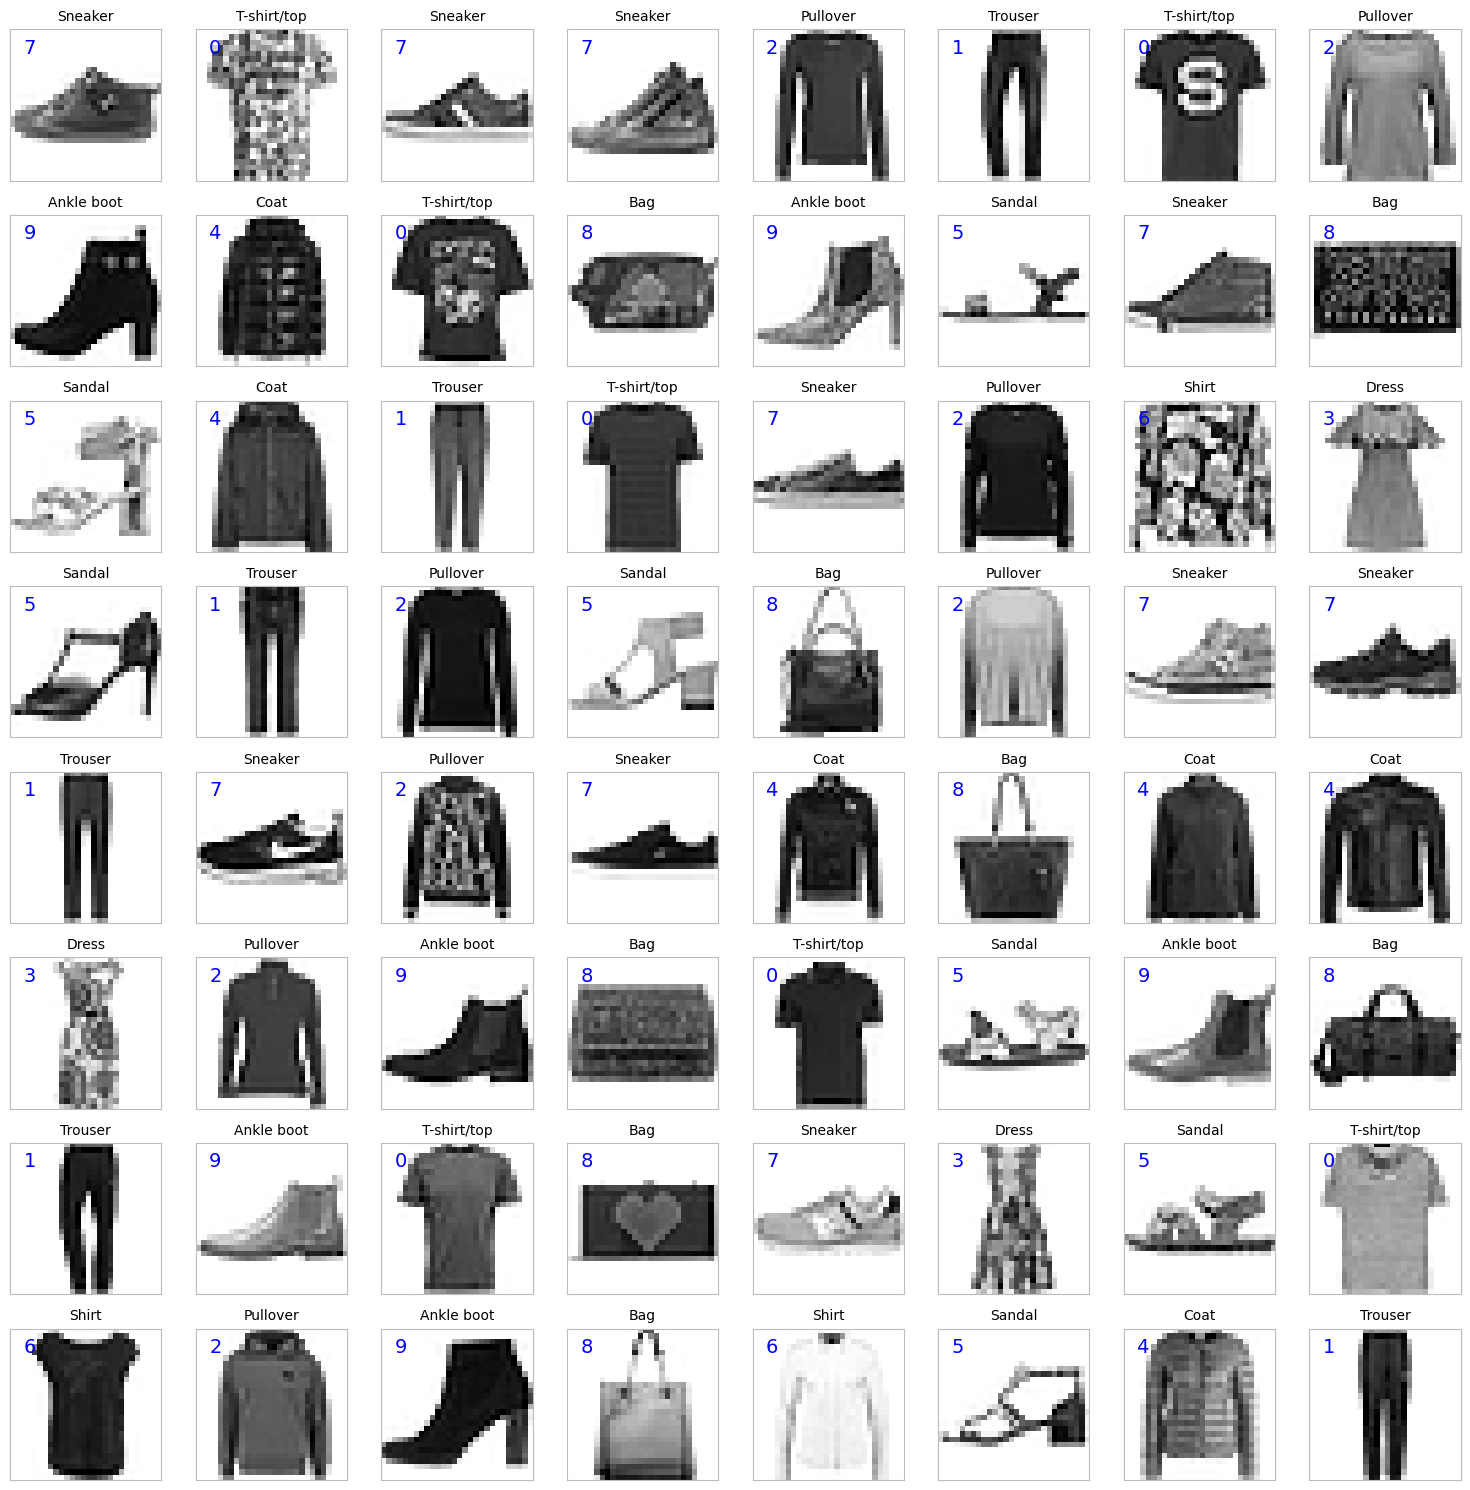

In [9]:
# Sample data plot

plot_df = train_df.sample(n = 64) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 15))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row.iloc[0]], fontsize=10)   # add name of the image

plt.tight_layout() 
plt.show()

In [10]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [11]:
X_train.max()

255

In [12]:
X_train = X_train /255.0
X_test = X_test /255.0

Preaper Model
Build tf.keras.SEquential model by taking tf.keras.layers.Dense

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(784//4,activation='relu'),
    tf.keras.layers.Dense(784//16,activation='relu'),
    tf.keras.layers.Dense(10) #for ten  calsses
    ])
#model.output_shape

In [14]:
X_train[:1].shape

(1, 784)

In [15]:
predictions = model(X_train[:1])
predictions.numpy().sum()

2024-06-17 21:29:11.159509: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


-2.1667128

In [16]:
tf.nn.softmax(predictions).numpy().sum()

1.0

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 196)               │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 49)                │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 10)                │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import sys
sys.float_info.max,sys.float_info.min

(1.7976931348623157e+308, 2.2250738585072014e-308)

#DEFINE OUR LOSS FUNCTION

In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [20]:
y_train[:1]

array([2])

In [21]:
loss_fn(y_train[:1],predictions).numpy()

4.123471

##COMPILE THE MODEL
1.Loss function
2.Optimizer
3.list metrix to moniter

##fit the model
1.Training features
2.Trsining target
3.validations
4.

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
                loss=loss_fn,
                metrics=['accuracy'])
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose='auto',
    validation_data=[X_test, y_test])

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7759 - loss: 0.6284 - val_accuracy: 0.8586 - val_loss: 0.3907
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8631 - loss: 0.3764 - val_accuracy: 0.8575 - val_loss: 0.3861
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8771 - loss: 0.3365 - val_accuracy: 0.8757 - val_loss: 0.3314
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8837 - loss: 0.3135 - val_accuracy: 0.8739 - val_loss: 0.3480
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8937 - loss: 0.2877 - val_accuracy: 0.8873 - val_loss: 0.3097
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8964 - loss: 0.2791 - val_accuracy: 0.8879 - val_loss: 0.3108
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9018 - loss: 0.2595 - val_accuracy: 0.8871 - val_loss: 0.3042
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9046 - l

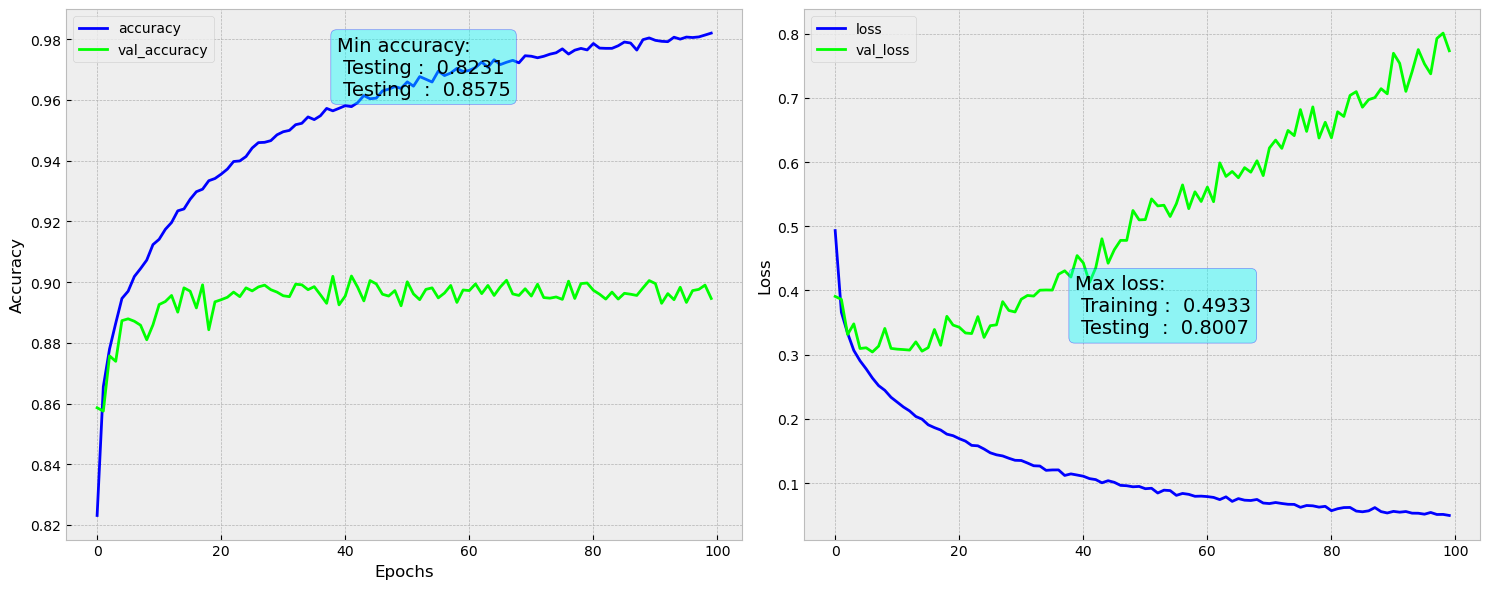

In [25]:
hist_df=pd.DataFrame(history.history)
fn_plot_hist(hist_df)

In [28]:
y_pred = model.predict(X_train)
y_pred = y_pred.argmax(axis = 1)
print('Acuuracy score on Train Data :',accuracy_score(y_train,y_pred))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Acuuracy score on Train Data : 0.9778666666666667


In [34]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6000
           1       1.00      1.00      1.00      6000
           2       0.91      0.97      0.94      6000
           3       0.99      0.98      0.99      6000
           4       0.96      0.93      0.94      6000
           5       1.00      1.00      1.00      6000
           6       0.96      0.94      0.95      6000
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00      6000
           9       1.00      1.00      1.00      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [35]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)
print('Acuuracy score on Train Data :',accuracy_score(y_test,y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Acuuracy score on Train Data : 0.8946


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1000
           1       0.98      0.99      0.99      1000
           2       0.78      0.88      0.82      1000
           3       0.94      0.89      0.91      1000
           4       0.85      0.82      0.83      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.71      0.72      1000
           7       0.94      0.94      0.94      1000
           8       0.98      0.97      0.98      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [37]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[827,   0,  20,   5,   2,   0, 143,   0,   3,   0],
       [  3, 989,   0,   7,   0,   0,   1,   0,   0,   0],
       [ 12,   0, 875,  11,  54,   0,  47,   0,   1,   0],
       [ 29,  12,   9, 888,  39,   0,  21,   0,   2,   0],
       [  1,   1, 119,  18, 821,   0,  37,   0,   3,   0],
       [  0,   0,   1,   0,   0, 959,   0,  23,   0,  17],
       [110,   3,  99,  19,  50,   1, 712,   0,   6,   0],
       [  0,   0,   0,   0,   0,  13,   0, 945,   0,  42],
       [  1,   1,   5,   1,   2,   4,  15,   1, 968,   2],
       [  0,   0,   0,   0,   0,   6,   0,  32,   0, 962]])

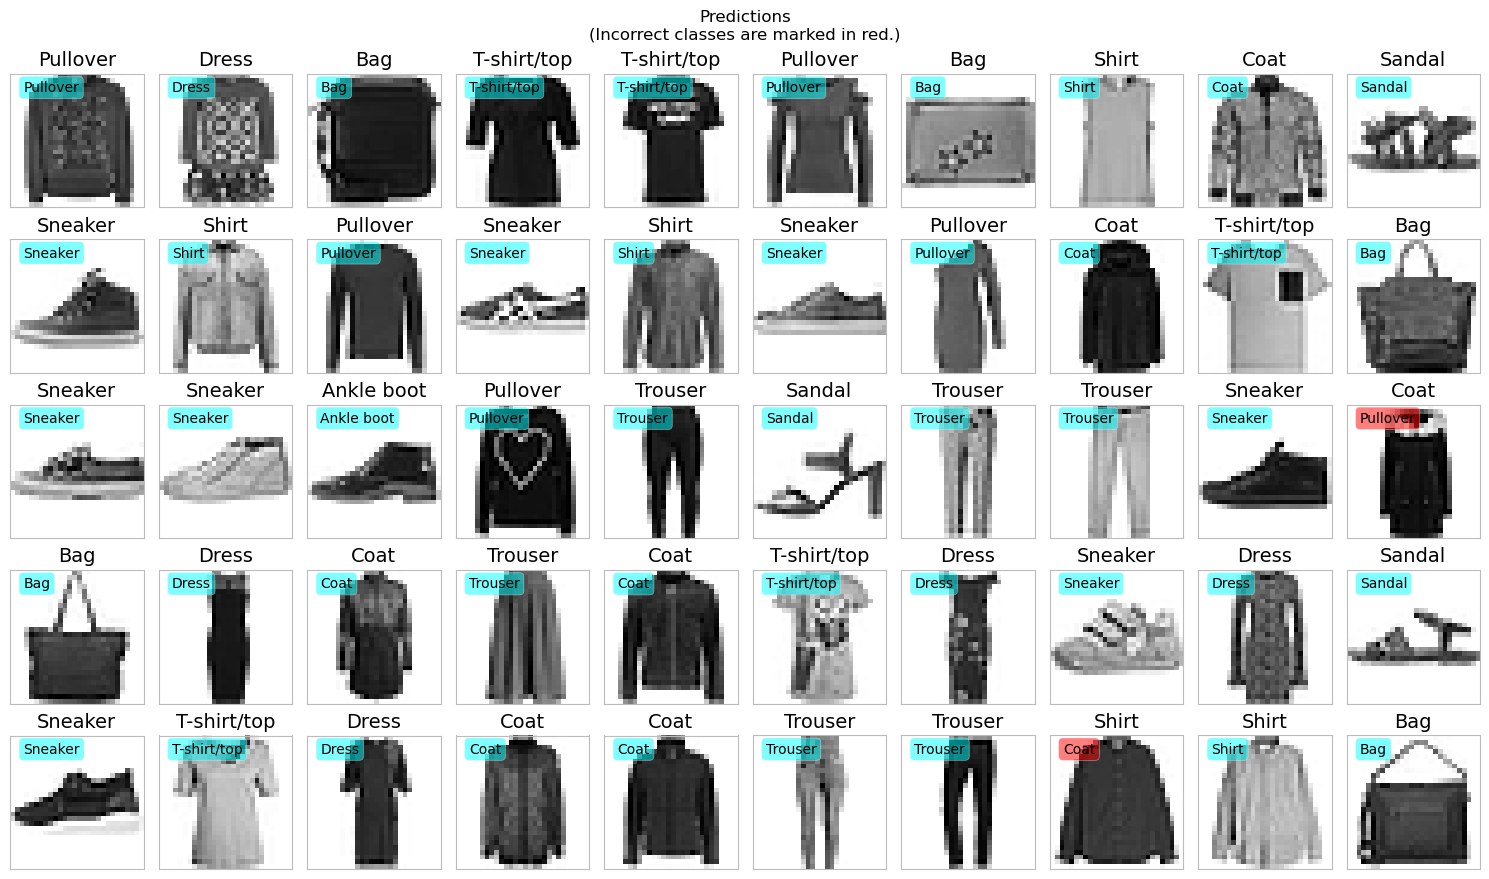

In [39]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

i = 0

fntsize = 14

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'

    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_names[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_names[row.iloc[-1]], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\n(Incorrect classes are marked in red.)')
plt.tight_layout()
plt.show()

In [26]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
6,0.901833,0.263696,0.8871,0.304216
